The data, findSigma, and private python files are available in the file fig2 of the repository:
https://github.com/Tiny-boot/privacy-amplification-by-decentralization



### Recreation of experiment

Successfully load dataset
Computing the sigmas:
   The per-step value of eps is 0.3916612592050584
   so we deduce that the sigma for Local DPSGD is 5.87105561253398
   Applying Bassily et al. bound, the sigma for Centralized DPSGD is  0.696820770826682
ceci est Kspotted 1
sigma due to spotted contribution 0.4598930068135968
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 1.9721682628289452
la 0.4598930068135968 1.9721682628289452
sigma due to spotted contribution 0.46453839072080483
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 1.9526418443850944
la 0.46453839072080483 1.9526418443850944
sigma due to spotted contribution 0.4692306976977827
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 1.9336878741336847
la 0.4692306976977827 1.9336878741336847
sigma due to spotted contribution 0.47397040171493204
   Non 

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


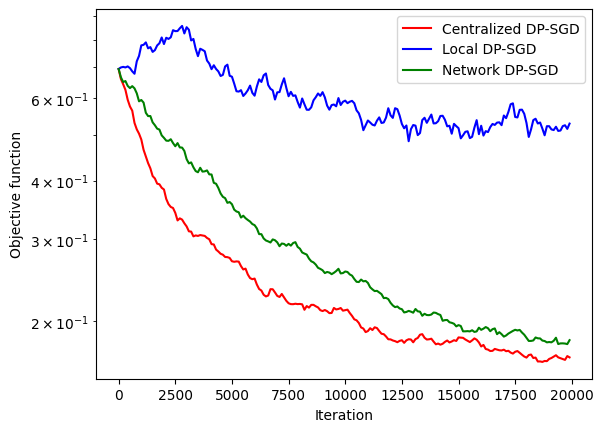

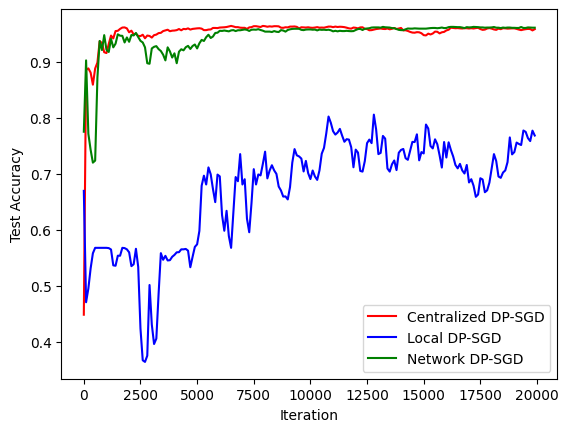

In [ ]:
import findSigma
import datatrue as data
import private

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import typer





app = typer.Typer()

###############################################################################
# Set the parameters
###############################################################################


def main(
    n_nodes: int=2000,
    eps_tot: float=10,
    delta: float=1e-6,
    n_iter: int=20000,
    conf: float=1.25,
    L: float=0.4,
    seed: int=1,
    n_trials: int=1,
    optimize_gamma: bool=False,
    save_array: bool=False,
    save_fig: bool=False,
    plot_fig: bool=True
    ):

    assert 0 <= delta <= 1
    assert 0 <= L <= 1

    np.random.seed(seed)

    X_train, X_test, y_train, y_test = data.load()
    print("Successfully load dataset")



    ###########################################################################
    # Find max sigma
    ###########################################################################

    print("Computing the sigmas:")
    # for local DP, with advanced composition
    sigma_loc = findSigma.loc(L, n_nodes, eps_tot, delta, n_iter)

    # for central DP, basic DPSGD result based on Bassily et al.
    sigma_ref = findSigma.dpsgd(L, n_nodes, eps_tot, delta, n_iter)

    # for network DP, bound with paper result
    sigma_net = findSigma.net(L, n_nodes, eps_tot, delta, n_iter)




    def score(y):
        # defining score to be able to evaluate the model on the test set during the training
        def evaluation(theta):
            from sklearn.linear_model._base import LinearClassifierMixin, SparseCoefMixin
            from sklearn.utils.validation import validate_data
            from sklearn.base import BaseEstimator
            class Truc(BaseEstimator, LinearClassifierMixin):
                def __init__(self):
                    self.intercept_ = np.expand_dims(theta[-1], axis=0)
                    self.coef_ = np.expand_dims(theta[:-1], axis=0)
                    self.classes_ = np.unique(y)

                def fit(self, X, y):
                    pass

            truc = Truc()

            return truc.score(X_test, y_test)

        return evaluation


    ###########################################################################
    # find optimal gamma for the three cases
    ###########################################################################


    n_train = X_train.shape[0]
    print('size of n ',n_train)

    best_gamma = np.array([0.06733333, 0.03416667, 0.03416667])

    if optimize_gamma:
        gamma_range = np.linspace(1e-3, .2, num=7)

        print("Testing various gamma", gamma_range)

        for i,sigma in enumerate([sigma_loc, sigma_ref, sigma_net]):
            print("optimizing ", sigma)

            best_objfun = 0
            for gamma in gamma_range:

                n_runs = 6
                objfun = np.zeros(n_runs)
                if sigma != sigma_ref:
                    mlr = private.MyPrivateRWSGDLogisticRegression(gamma, n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = conf *n_iter + n_iter/n_nodes,random_state=None, score=score, freq_obj_eval=1000, L=L)
                else :
                    mlr = private.MyPrivateRWSGDLogisticRegression(gamma, n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = n_iter,random_state=None, score=score, freq_obj_eval=1000, L=L)

                for r in range(n_runs):
                    mlr.fit(X_train, y_train)
                    objfun[r] = mlr.obj_list_[-1]
                if objfun.mean() < best_objfun:
                    best_objfun = objfun.mean()
                    best_gamma[i] = gamma


        print("Found the following :", best_gamma)
        if save_array:
            np.save('result/gamma.txt', best_gamma)


    ###########################################################################
    # Core experiments n_trials runs for the three methods
    ###########################################################################

    freq_eval = 100
    obj_list_ref = np.zeros((n_trials, int(n_iter/freq_eval)))
    obj_list_loc = np.zeros((n_trials, int(n_iter/freq_eval)))
    obj_list_net = np.zeros((n_trials, int(n_iter/freq_eval)))

    score_ref = np.zeros((n_trials, int(n_iter/freq_eval)))
    score_loc = np.zeros((n_trials, int(n_iter/freq_eval)))
    score_net = np.zeros((n_trials, int(n_iter/freq_eval)))



    for i in range(n_trials):
        print("Computing trial ", i)
        # put option contribution the noise, but with a max number of iteration equal to the whole experiment, so we always compute the gradient
        mlr_ref = private.MyPrivateRWSGDLogisticRegression(best_gamma[1], n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = n_iter,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_ref.fit(X_train, y_train)

        mlr_loc = private.MyPrivateRWSGDLogisticRegression(best_gamma[0], n_iter, n_nodes, sigma_loc, 0, stopping_criteria = "contribute_then_nothing",max_updates_per_node = conf * n_iter/n_nodes,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_loc.fit(X_train, y_train)

        mlr_net = private.MyPrivateRWSGDLogisticRegression(best_gamma[2], n_iter, n_nodes, sigma_net, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = conf * n_iter/n_nodes,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_net.fit(X_train, y_train)


        obj_list_ref[i] = mlr_ref.obj_list_
        obj_list_loc[i] = mlr_loc.obj_list_
        obj_list_net[i] = mlr_net.obj_list_

        score_ref[i] = mlr_ref.scores_
        score_loc[i] = mlr_loc.scores_
        score_net[i] = mlr_net.scores_

    ###########################################################################
    # save objective function and score over iterations
    ###########################################################################

    if save_array:
        np.save("result/dpsgd", obj_list_ref)
        np.save("result/localsgd", obj_list_loc)
        np.save("result/networksgd", obj_list_net)

        np.save("result/dpsgd_score",score_ref)
        np.save("result/localsgd_score",score_loc)
        np.save("result/networksgd_score", score_net)


    ###########################################################################
    # plot figure and save them
    ###########################################################################

    if plot_fig:
        # define x axis
        iter_list = np.arange(len(obj_list_ref[0])) * mlr_ref.freq_obj_eval
        # plot
        plt.plot(iter_list, obj_list_ref.mean(axis=0), label="Centralized DP-SGD", color="r")
        plt.plot(iter_list, obj_list_loc.mean(axis=0), label="Local DP-SGD", color="b")
        plt.plot(iter_list, obj_list_net.mean(axis=0), label="Network DP-SGD", color="g")

        plt.xlabel("Iteration")
        plt.ylabel("Objective function")
        plt.yscale("log")
        plt.legend(loc='upper right')
        if save_fig:
            plt.savefig("result/objfun.pdf")
        plt.show()


        plt.figure()
        plt.plot(iter_list, score_ref.mean(axis=0), label="Centralized DP-SGD", color="r")
        plt.plot(iter_list, score_loc.mean(axis=0), label="Local DP-SGD", color="b")
        plt.plot(iter_list, score_net.mean(axis=0), label="Network DP-SGD", color="g")

        plt.xlabel("Iteration")
        plt.ylabel("Test Accuracy")
        plt.legend(loc='lower right')
        if save_fig:
            plt.savefig("result/accuracy.pdf",bbox_inches='tight', pad_inches=0)

        plt.show()
if __name__ == "__main__":
    # typer.run(main)  # Replace this line
    main()  # Directly call main function instead

### Experiment

#### Spambase

We first use it on a the smaller dataset spambase with only 4601 instances.

Successfully load dataset
Computing the sigmas:
   The per-step value of eps is 0.3916612592050584
   so we deduce that the sigma for Local DPSGD is 5.87105561253398
   Applying Bassily et al. bound, the sigma for Centralized DPSGD is  0.696820770826682
ceci est Kspotted 1
sigma due to spotted contribution 0.4598930068135968
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 1.9721682628289452
la 0.4598930068135968 1.9721682628289452
sigma due to spotted contribution 0.46453839072080483
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 1.9526418443850944
la 0.46453839072080483 1.9526418443850944
sigma due to spotted contribution 0.4692306976977827
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 1.9336878741336847
la 0.4692306976977827 1.9336878741336847
sigma due to spotted contribution 0.47397040171493204
   Non 

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


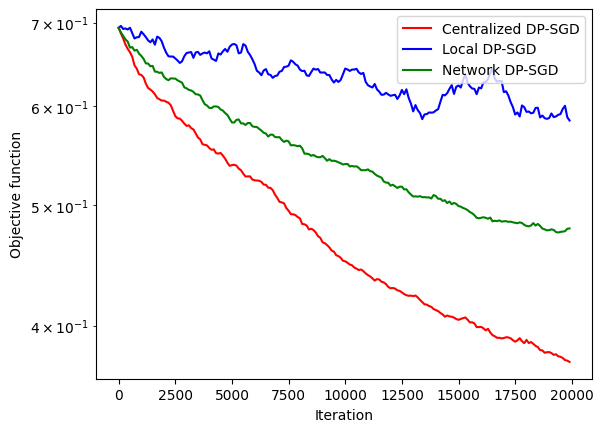

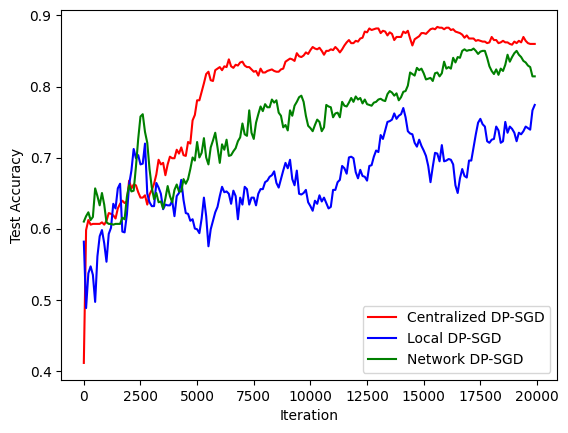

In [ ]:
import findSigma
import data
import private

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import typer





app = typer.Typer()

###############################################################################
# Set the parameters
###############################################################################


def main(
    n_nodes: int=2000,
    eps_tot: float=10,
    delta: float=1e-6,
    n_iter: int=20000,
    conf: float=1.25,
    L: float=0.4,
    seed: int=1,
    n_trials: int=1,
    optimize_gamma: bool=False,
    save_array: bool=False,
    save_fig: bool=False,
    plot_fig: bool=True
    ):

    assert 0 <= delta <= 1
    assert 0 <= L <= 1

    np.random.seed(seed)

    X_train, X_test, y_train, y_test = data.load()
    print("Successfully load dataset")



    ###########################################################################
    # Find max sigma
    ###########################################################################

    print("Computing the sigmas:")
    # for local DP, with advanced composition
    sigma_loc = findSigma.loc(L, n_nodes, eps_tot, delta, n_iter)

    # for central DP, basic DPSGD result based on Bassily et al.
    sigma_ref = findSigma.dpsgd(L, n_nodes, eps_tot, delta, n_iter)

    # for network DP, bound with paper result
    sigma_net = findSigma.net(L, n_nodes, eps_tot, delta, n_iter)




    def score(y):
        # defining score to be able to evaluate the model on the test set during the training
        def evaluation(theta):
            from sklearn.linear_model._base import LinearClassifierMixin, SparseCoefMixin
            from sklearn.utils.validation import validate_data
            from sklearn.base import BaseEstimator
            class Truc(BaseEstimator, LinearClassifierMixin):
                def __init__(self):
                    self.intercept_ = np.expand_dims(theta[-1], axis=0)
                    self.coef_ = np.expand_dims(theta[:-1], axis=0)
                    self.classes_ = np.unique(y)

                def fit(self, X, y):
                    pass

            truc = Truc()

            return truc.score(X_test, y_test)

        return evaluation


    ###########################################################################
    # find optimal gamma for the three cases
    ###########################################################################


    n_train = X_train.shape[0]
    print('size of n ',n_train)

    best_gamma = np.array([0.06733333, 0.03416667, 0.03416667])

    if optimize_gamma:
        gamma_range = np.linspace(1e-3, .2, num=7)

        print("Testing various gamma", gamma_range)

        for i,sigma in enumerate([sigma_loc, sigma_ref, sigma_net]):
            print("optimizing ", sigma)

            best_objfun = 0
            for gamma in gamma_range:

                n_runs = 6
                objfun = np.zeros(n_runs)
                if sigma != sigma_ref:
                    mlr = private.MyPrivateRWSGDLogisticRegression(gamma, n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = conf *n_iter + n_iter/n_nodes,random_state=None, score=score, freq_obj_eval=1000, L=L)
                else :
                    mlr = private.MyPrivateRWSGDLogisticRegression(gamma, n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = n_iter,random_state=None, score=score, freq_obj_eval=1000, L=L)

                for r in range(n_runs):
                    mlr.fit(X_train, y_train)
                    objfun[r] = mlr.obj_list_[-1]
                if objfun.mean() < best_objfun:
                    best_objfun = objfun.mean()
                    best_gamma[i] = gamma


        print("Found the following :", best_gamma)
        if save_array:
            np.save('result/gamma.txt', best_gamma)


    ###########################################################################
    # Core experiments n_trials runs for the three methods
    ###########################################################################

    freq_eval = 100
    obj_list_ref = np.zeros((n_trials, int(n_iter/freq_eval)))
    obj_list_loc = np.zeros((n_trials, int(n_iter/freq_eval)))
    obj_list_net = np.zeros((n_trials, int(n_iter/freq_eval)))

    score_ref = np.zeros((n_trials, int(n_iter/freq_eval)))
    score_loc = np.zeros((n_trials, int(n_iter/freq_eval)))
    score_net = np.zeros((n_trials, int(n_iter/freq_eval)))



    for i in range(n_trials):
        print("Computing trial ", i)
        # put option contribution the noise, but with a max number of iteration equal to the whole experiment, so we always compute the gradient
        mlr_ref = private.MyPrivateRWSGDLogisticRegression(best_gamma[1], n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = n_iter,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_ref.fit(X_train, y_train)

        mlr_loc = private.MyPrivateRWSGDLogisticRegression(best_gamma[0], n_iter, n_nodes, sigma_loc, 0, stopping_criteria = "contribute_then_nothing",max_updates_per_node = conf * n_iter/n_nodes,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_loc.fit(X_train, y_train)

        mlr_net = private.MyPrivateRWSGDLogisticRegression(best_gamma[2], n_iter, n_nodes, sigma_net, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = conf * n_iter/n_nodes,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_net.fit(X_train, y_train)


        obj_list_ref[i] = mlr_ref.obj_list_
        obj_list_loc[i] = mlr_loc.obj_list_
        obj_list_net[i] = mlr_net.obj_list_

        score_ref[i] = mlr_ref.scores_
        score_loc[i] = mlr_loc.scores_
        score_net[i] = mlr_net.scores_

    ###########################################################################
    # save objective function and score over iterations
    ###########################################################################

    if save_array:
        np.save("result/dpsgd", obj_list_ref)
        np.save("result/localsgd", obj_list_loc)
        np.save("result/networksgd", obj_list_net)

        np.save("result/dpsgd_score",score_ref)
        np.save("result/localsgd_score",score_loc)
        np.save("result/networksgd_score", score_net)


    ###########################################################################
    # plot figure and save them
    ###########################################################################

    if plot_fig:
        # define x axis
        iter_list = np.arange(len(obj_list_ref[0])) * mlr_ref.freq_obj_eval
        # plot
        plt.plot(iter_list, obj_list_ref.mean(axis=0), label="Centralized DP-SGD", color="r")
        plt.plot(iter_list, obj_list_loc.mean(axis=0), label="Local DP-SGD", color="b")
        plt.plot(iter_list, obj_list_net.mean(axis=0), label="Network DP-SGD", color="g")

        plt.xlabel("Iteration")
        plt.ylabel("Objective function")
        plt.yscale("log")
        plt.legend(loc='upper right')
        if save_fig:
            plt.savefig("result/objfun.pdf")
        plt.show()


        plt.figure()
        plt.plot(iter_list, score_ref.mean(axis=0), label="Centralized DP-SGD", color="r")
        plt.plot(iter_list, score_loc.mean(axis=0), label="Local DP-SGD", color="b")
        plt.plot(iter_list, score_net.mean(axis=0), label="Network DP-SGD", color="g")

        plt.xlabel("Iteration")
        plt.ylabel("Test Accuracy")
        plt.legend(loc='lower right')
        if save_fig:
            plt.savefig("result/accuracy.pdf",bbox_inches='tight', pad_inches=0)

        plt.show()
if __name__ == "__main__":
    # typer.run(main)  # Replace this line
    main()  # Directly call main function instead

We can see that the performances of the network DP-SGD are negatively impacted by the size of the dataset, as its performances are worse than the centralised DP-SGD but we still obtain better results than Local DP-SGD

#### Cardiovascular-Disease-dataset

Bigger dataset with 70000 instances

Successfully load dataset
Computing the sigmas:
   The per-step value of eps is 0.3916612592050584
   so we deduce that the sigma for Local DPSGD is 5.87105561253398
   Applying Bassily et al. bound, the sigma for Centralized DPSGD is  0.696820770826682
ceci est Kspotted 1
sigma due to spotted contribution 0.4598930068135968
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 1.9721682628289452
la 0.4598930068135968 1.9721682628289452
sigma due to spotted contribution 0.46453839072080483
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 1.9526418443850944
la 0.46453839072080483 1.9526418443850944
sigma due to spotted contribution 0.4692306976977827
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 1.9336878741336847
la 0.4692306976977827 1.9336878741336847
sigma due to spotted contribution 0.47397040171493204
   Non 

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


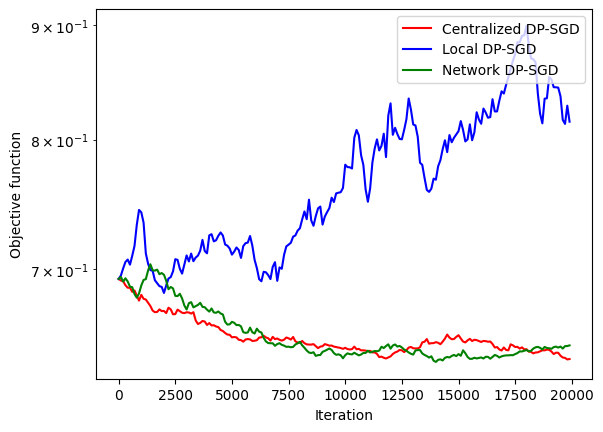

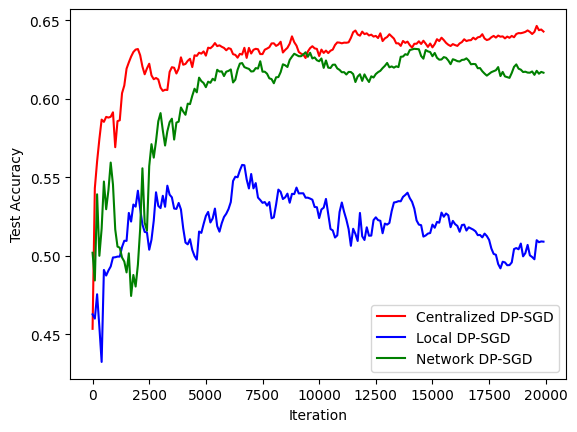

In [ ]:
import findSigma
import data
import private

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import typer





app = typer.Typer()

###############################################################################
# Set the parameters
###############################################################################


def main(
    n_nodes: int=2000,
    eps_tot: float=10,
    delta: float=1e-6,
    n_iter: int=20000,
    conf: float=1.25,
    L: float=0.4,
    seed: int=1,
    n_trials: int=1,
    optimize_gamma: bool=False,
    save_array: bool=False,
    save_fig: bool=False,
    plot_fig: bool=True
    ):

    assert 0 <= delta <= 1
    assert 0 <= L <= 1

    np.random.seed(seed)

    X_train, X_test, y_train, y_test = data.load()
    print("Successfully load dataset")



    ###########################################################################
    # Find max sigma
    ###########################################################################

    print("Computing the sigmas:")
    # for local DP, with advanced composition
    sigma_loc = findSigma.loc(L, n_nodes, eps_tot, delta, n_iter)

    # for central DP, basic DPSGD result based on Bassily et al.
    sigma_ref = findSigma.dpsgd(L, n_nodes, eps_tot, delta, n_iter)

    # for network DP, bound with paper result
    sigma_net = findSigma.net(L, n_nodes, eps_tot, delta, n_iter)




    def score(y):
        # defining score to be able to evaluate the model on the test set during the training
        def evaluation(theta):
            from sklearn.linear_model._base import LinearClassifierMixin, SparseCoefMixin
            from sklearn.utils.validation import validate_data
            from sklearn.base import BaseEstimator
            class Truc(BaseEstimator, LinearClassifierMixin):
                def __init__(self):
                    self.intercept_ = np.expand_dims(theta[-1], axis=0)
                    self.coef_ = np.expand_dims(theta[:-1], axis=0)
                    self.classes_ = np.unique(y)

                def fit(self, X, y):
                    pass

            truc = Truc()

            return truc.score(X_test, y_test)

        return evaluation


    ###########################################################################
    # find optimal gamma for the three cases
    ###########################################################################


    n_train = X_train.shape[0]
    print('size of n ',n_train)

    best_gamma = np.array([0.06733333, 0.03416667, 0.03416667])

    if optimize_gamma:
        gamma_range = np.linspace(1e-3, .2, num=7)

        print("Testing various gamma", gamma_range)

        for i,sigma in enumerate([sigma_loc, sigma_ref, sigma_net]):
            print("optimizing ", sigma)

            best_objfun = 0
            for gamma in gamma_range:

                n_runs = 6
                objfun = np.zeros(n_runs)
                if sigma != sigma_ref:
                    mlr = private.MyPrivateRWSGDLogisticRegression(gamma, n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = conf *n_iter + n_iter/n_nodes,random_state=None, score=score, freq_obj_eval=1000, L=L)
                else :
                    mlr = private.MyPrivateRWSGDLogisticRegression(gamma, n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = n_iter,random_state=None, score=score, freq_obj_eval=1000, L=L)

                for r in range(n_runs):
                    mlr.fit(X_train, y_train)
                    objfun[r] = mlr.obj_list_[-1]
                if objfun.mean() < best_objfun:
                    best_objfun = objfun.mean()
                    best_gamma[i] = gamma


        print("Found the following :", best_gamma)
        if save_array:
            np.save('result/gamma.txt', best_gamma)


    ###########################################################################
    # Core experiments n_trials runs for the three methods
    ###########################################################################

    freq_eval = 100
    obj_list_ref = np.zeros((n_trials, int(n_iter/freq_eval)))
    obj_list_loc = np.zeros((n_trials, int(n_iter/freq_eval)))
    obj_list_net = np.zeros((n_trials, int(n_iter/freq_eval)))

    score_ref = np.zeros((n_trials, int(n_iter/freq_eval)))
    score_loc = np.zeros((n_trials, int(n_iter/freq_eval)))
    score_net = np.zeros((n_trials, int(n_iter/freq_eval)))



    for i in range(n_trials):
        print("Computing trial ", i)
        # put option contribution the noise, but with a max number of iteration equal to the whole experiment, so we always compute the gradient
        mlr_ref = private.MyPrivateRWSGDLogisticRegression(best_gamma[1], n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = n_iter,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_ref.fit(X_train, y_train)

        mlr_loc = private.MyPrivateRWSGDLogisticRegression(best_gamma[0], n_iter, n_nodes, sigma_loc, 0, stopping_criteria = "contribute_then_nothing",max_updates_per_node = conf * n_iter/n_nodes,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_loc.fit(X_train, y_train)

        mlr_net = private.MyPrivateRWSGDLogisticRegression(best_gamma[2], n_iter, n_nodes, sigma_net, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = conf * n_iter/n_nodes,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_net.fit(X_train, y_train)


        obj_list_ref[i] = mlr_ref.obj_list_
        obj_list_loc[i] = mlr_loc.obj_list_
        obj_list_net[i] = mlr_net.obj_list_

        score_ref[i] = mlr_ref.scores_
        score_loc[i] = mlr_loc.scores_
        score_net[i] = mlr_net.scores_

    ###########################################################################
    # save objective function and score over iterations
    ###########################################################################

    if save_array:
        np.save("result/dpsgd", obj_list_ref)
        np.save("result/localsgd", obj_list_loc)
        np.save("result/networksgd", obj_list_net)

        np.save("result/dpsgd_score",score_ref)
        np.save("result/localsgd_score",score_loc)
        np.save("result/networksgd_score", score_net)


    ###########################################################################
    # plot figure and save them
    ###########################################################################

    if plot_fig:
        # define x axis
        iter_list = np.arange(len(obj_list_ref[0])) * mlr_ref.freq_obj_eval
        # plot
        plt.plot(iter_list, obj_list_ref.mean(axis=0), label="Centralized DP-SGD", color="r")
        plt.plot(iter_list, obj_list_loc.mean(axis=0), label="Local DP-SGD", color="b")
        plt.plot(iter_list, obj_list_net.mean(axis=0), label="Network DP-SGD", color="g")

        plt.xlabel("Iteration")
        plt.ylabel("Objective function")
        plt.yscale("log")
        plt.legend(loc='upper right')
        if save_fig:
            plt.savefig("result/objfun.pdf")
        plt.show()


        plt.figure()
        plt.plot(iter_list, score_ref.mean(axis=0), label="Centralized DP-SGD", color="r")
        plt.plot(iter_list, score_loc.mean(axis=0), label="Local DP-SGD", color="b")
        plt.plot(iter_list, score_net.mean(axis=0), label="Network DP-SGD", color="g")

        plt.xlabel("Iteration")
        plt.ylabel("Test Accuracy")
        plt.legend(loc='lower right')
        if save_fig:
            plt.savefig("result/accuracy.pdf",bbox_inches='tight', pad_inches=0)

        plt.show()
if __name__ == "__main__":
    # typer.run(main)  # Replace this line
    main()  # Directly call main function instead

We can see that with higher-dimension data the Local DP-SGD performances worsen. The network DP-SGP performances are quite close to the ones of centralised and get better with more iterations.

## Modification of parameters

### Increase of the number of updates per node

We change the number of updates from 1 to 50 and see how it impacts the results

Successfully load dataset
Computing the sigmas:
   The per-step value of eps is 0.3916612592050584
   so we deduce that the sigma for Local DPSGD is 5.87105561253398
   Applying Bassily et al. bound, the sigma for Centralized DPSGD is  0.696820770826682
ceci est Kspotted 1
sigma due to spotted contribution 0.4598930068135968
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 1.9721682628289452
la 0.4598930068135968 1.9721682628289452
sigma due to spotted contribution 0.46453839072080483
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 1.9526418443850944
la 0.46453839072080483 1.9526418443850944
sigma due to spotted contribution 0.4692306976977827
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 1.9336878741336847
la 0.4692306976977827 1.9336878741336847
sigma due to spotted contribution 0.47397040171493204
   Non 

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


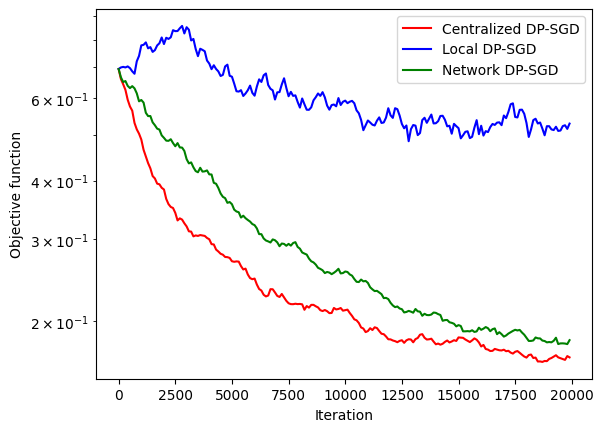

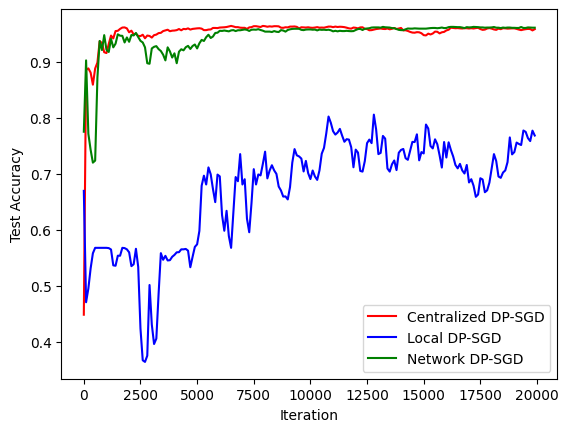

In [ ]:
import findSigma
import datatrue as data
import private

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import typer





app = typer.Typer()

###############################################################################
# Set the parameters
###############################################################################


def main(
    n_nodes: int=2000,
    eps_tot: float=10,
    delta: float=1e-6,
    n_iter: int=20000,
    conf: float=1.25,
    L: float=0.4,
    seed: int=1,
    n_trials: int=1,
    optimize_gamma: bool=False,
    save_array: bool=False,
    save_fig: bool=False,
    plot_fig: bool=True
    ):

    assert 0 <= delta <= 1
    assert 0 <= L <= 1

    np.random.seed(seed)

    X_train, X_test, y_train, y_test = data.load()
    print("Successfully load dataset")



    ###########################################################################
    # Find max sigma
    ###########################################################################

    print("Computing the sigmas:")
    # for local DP, with advanced composition
    sigma_loc = findSigma.loc(L, n_nodes, eps_tot, delta, n_iter)

    # for central DP, basic DPSGD result based on Bassily et al.
    sigma_ref = findSigma.dpsgd(L, n_nodes, eps_tot, delta, n_iter)

    # for network DP, bound with paper result
    sigma_net = findSigma.net(L, n_nodes, eps_tot, delta, n_iter)




    def score(y):
        # defining score to be able to evaluate the model on the test set during the training
        def evaluation(theta):
            from sklearn.linear_model._base import LinearClassifierMixin, SparseCoefMixin
            from sklearn.utils.validation import validate_data
            from sklearn.base import BaseEstimator
            class Truc(BaseEstimator, LinearClassifierMixin):
                def __init__(self):
                    self.intercept_ = np.expand_dims(theta[-1], axis=0)
                    self.coef_ = np.expand_dims(theta[:-1], axis=0)
                    self.classes_ = np.unique(y)

                def fit(self, X, y):
                    pass

            truc = Truc()

            return truc.score(X_test, y_test)

        return evaluation


    ###########################################################################
    # find optimal gamma for the three cases
    ###########################################################################


    n_train = X_train.shape[0]
    print('size of n ',n_train)

    best_gamma = np.array([0.06733333, 0.03416667, 0.03416667])

    if optimize_gamma:
        gamma_range = np.linspace(1e-3, .2, num=7)

        print("Testing various gamma", gamma_range)

        for i,sigma in enumerate([sigma_loc, sigma_ref, sigma_net]):
            print("optimizing ", sigma)

            best_objfun = 0
            for gamma in gamma_range:

                n_runs = 6
                objfun = np.zeros(n_runs)
                if sigma != sigma_ref:
                    mlr = private.MyPrivateRWSGDLogisticRegression(gamma, n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = conf *n_iter + n_iter/n_nodes,random_state=None, score=score, freq_obj_eval=1000, L=L)
                else :
                    mlr = private.MyPrivateRWSGDLogisticRegression(gamma, n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = n_iter,random_state=None, score=score, freq_obj_eval=1000, L=L)

                for r in range(n_runs):
                    mlr.fit(X_train, y_train)
                    objfun[r] = mlr.obj_list_[-1]
                if objfun.mean() < best_objfun:
                    best_objfun = objfun.mean()
                    best_gamma[i] = gamma


        print("Found the following :", best_gamma)
        if save_array:
            np.save('result/gamma.txt', best_gamma)


    ###########################################################################
    # Core experiments n_trials runs for the three methods
    ###########################################################################

    freq_eval = 100
    obj_list_ref = np.zeros((n_trials, int(n_iter/freq_eval)))
    obj_list_loc = np.zeros((n_trials, int(n_iter/freq_eval)))
    obj_list_net = np.zeros((n_trials, int(n_iter/freq_eval)))

    score_ref = np.zeros((n_trials, int(n_iter/freq_eval)))
    score_loc = np.zeros((n_trials, int(n_iter/freq_eval)))
    score_net = np.zeros((n_trials, int(n_iter/freq_eval)))



    for i in range(n_trials):
        print("Computing trial ", i)
        # put option contribution the noise, but with a max number of iteration equal to the whole experiment, so we always compute the gradient
        mlr_ref = private.MyPrivateRWSGDLogisticRegression(best_gamma[1], n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = n_iter,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_ref.fit(X_train, y_train)

        mlr_loc = private.MyPrivateRWSGDLogisticRegression(best_gamma[0], n_iter, n_nodes, sigma_loc, 0, stopping_criteria = "contribute_then_nothing",max_updates_per_node = conf * n_iter/n_nodes,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_loc.fit(X_train, y_train)

        mlr_net = private.MyPrivateRWSGDLogisticRegression(best_gamma[2], n_iter, n_nodes, sigma_net, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = conf * n_iter/n_nodes,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_net.fit(X_train, y_train)


        obj_list_ref[i] = mlr_ref.obj_list_
        obj_list_loc[i] = mlr_loc.obj_list_
        obj_list_net[i] = mlr_net.obj_list_

        score_ref[i] = mlr_ref.scores_
        score_loc[i] = mlr_loc.scores_
        score_net[i] = mlr_net.scores_

    ###########################################################################
    # save objective function and score over iterations
    ###########################################################################

    if save_array:
        np.save("result/dpsgd", obj_list_ref)
        np.save("result/localsgd", obj_list_loc)
        np.save("result/networksgd", obj_list_net)

        np.save("result/dpsgd_score",score_ref)
        np.save("result/localsgd_score",score_loc)
        np.save("result/networksgd_score", score_net)


    ###########################################################################
    # plot figure and save them
    ###########################################################################

    if plot_fig:
        # define x axis
        iter_list = np.arange(len(obj_list_ref[0])) * mlr_ref.freq_obj_eval
        # plot
        plt.plot(iter_list, obj_list_ref.mean(axis=0), label="Centralized DP-SGD", color="r")
        plt.plot(iter_list, obj_list_loc.mean(axis=0), label="Local DP-SGD", color="b")
        plt.plot(iter_list, obj_list_net.mean(axis=0), label="Network DP-SGD", color="g")

        plt.xlabel("Iteration")
        plt.ylabel("Objective function")
        plt.yscale("log")
        plt.legend(loc='upper right')
        if save_fig:
            plt.savefig("result/objfun.pdf")
        plt.show()


        plt.figure()
        plt.plot(iter_list, score_ref.mean(axis=0), label="Centralized DP-SGD", color="r")
        plt.plot(iter_list, score_loc.mean(axis=0), label="Local DP-SGD", color="b")
        plt.plot(iter_list, score_net.mean(axis=0), label="Network DP-SGD", color="g")

        plt.xlabel("Iteration")
        plt.ylabel("Test Accuracy")
        plt.legend(loc='lower right')
        if save_fig:
            plt.savefig("result/accuracy.pdf",bbox_inches='tight', pad_inches=0)

        plt.show()
if __name__ == "__main__":
    # typer.run(main)  # Replace this line
    main()  # Directly call main function instead

We can see that increasing the updates per nodes it reduces very minimaly the accuracy and does not have a significant impact.

### Increasing number of iterations

We increase the iterations from 2000 to 100000.

Successfully load dataset
Computing the sigmas:
   The per-step value of eps is 0.05306721820880947
   so we deduce that the sigma for Local DPSGD is 48.18836496113134
   Applying Bassily et al. bound, the sigma for Centralized DPSGD is  5.485435197385522
ceci est Kspotted 6
sigma due to spotted contribution 3.068666974219616
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 2.2679935022532867
ici 3.068666974219616 2.2679935022532867
sigma due to spotted contribution 3.038284132890709
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 2.290902527528572
ici 3.038284132890709 2.290902527528572
sigma due to spotted contribution 3.0082021117729787
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 2.3145152589583495
ici 3.0082021117729787 2.3145152589583495
sigma due to spotted contribution 2.978417932448494
   Non optim

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


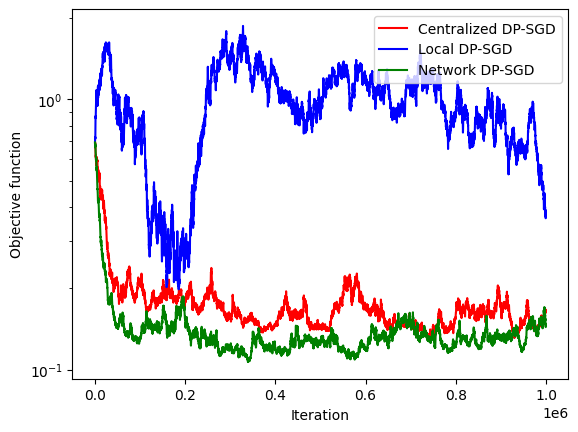

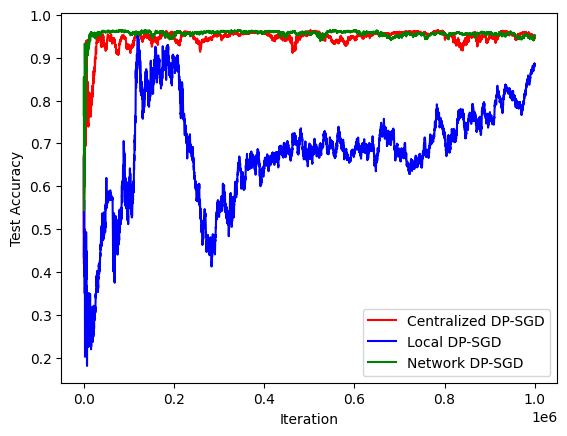

In [ ]:
import findSigma
import data
import private

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import typer





app = typer.Typer()

###############################################################################
# Set the parameters
###############################################################################


def main(
    n_nodes: int=2000,
    eps_tot: float=10,
    delta: float=1e-6,
    n_iter: int=1000000,
    conf: float=1.25,
    L: float=0.4,
    seed: int=1,
    n_trials: int=1,
    optimize_gamma: bool=False,
    save_array: bool=False,
    save_fig: bool=False,
    plot_fig: bool=True
    ):

    assert 0 <= delta <= 1
    assert 0 <= L <= 1

    np.random.seed(seed)

    X_train, X_test, y_train, y_test = data.load()
    print("Successfully load dataset")



    ###########################################################################
    # Find max sigma
    ###########################################################################

    print("Computing the sigmas:")
    # for local DP, with advanced composition
    sigma_loc = findSigma.loc(L, n_nodes, eps_tot, delta, n_iter)

    # for central DP, basic DPSGD result based on Bassily et al.
    sigma_ref = findSigma.dpsgd(L, n_nodes, eps_tot, delta, n_iter)

    # for network DP, bound with paper result
    sigma_net = findSigma.net(L, n_nodes, eps_tot, delta, n_iter)




    def score(y):
        # defining score to be able to evaluate the model on the test set during the training
        def evaluation(theta):
            from sklearn.linear_model._base import LinearClassifierMixin, SparseCoefMixin
            from sklearn.utils.validation import validate_data
            from sklearn.base import BaseEstimator
            class Truc(BaseEstimator, LinearClassifierMixin):
                def __init__(self):
                    self.intercept_ = np.expand_dims(theta[-1], axis=0)
                    self.coef_ = np.expand_dims(theta[:-1], axis=0)
                    self.classes_ = np.unique(y)

                def fit(self, X, y):
                    pass

            truc = Truc()

            return truc.score(X_test, y_test)

        return evaluation


    ###########################################################################
    # find optimal gamma for the three cases
    ###########################################################################


    n_train = X_train.shape[0]
    print('size of n ',n_train)

    best_gamma = np.array([0.06733333, 0.03416667, 0.03416667])

    if optimize_gamma:
        gamma_range = np.linspace(1e-3, .2, num=7)

        print("Testing various gamma", gamma_range)

        for i,sigma in enumerate([sigma_loc, sigma_ref, sigma_net]):
            print("optimizing ", sigma)

            best_objfun = 0
            for gamma in gamma_range:

                n_runs = 6
                objfun = np.zeros(n_runs)
                if sigma != sigma_ref:
                    mlr = private.MyPrivateRWSGDLogisticRegression(gamma, n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = conf *n_iter + n_iter/n_nodes,random_state=None, score=score, freq_obj_eval=1000, L=L)
                else :
                    mlr = private.MyPrivateRWSGDLogisticRegression(gamma, n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = n_iter,random_state=None, score=score, freq_obj_eval=1000, L=L)

                for r in range(n_runs):
                    mlr.fit(X_train, y_train)
                    objfun[r] = mlr.obj_list_[-1]
                if objfun.mean() < best_objfun:
                    best_objfun = objfun.mean()
                    best_gamma[i] = gamma


        print("Found the following :", best_gamma)
        if save_array:
            np.save('result/gamma.txt', best_gamma)


    ###########################################################################
    # Core experiments n_trials runs for the three methods
    ###########################################################################

    freq_eval = 100
    obj_list_ref = np.zeros((n_trials, int(n_iter/freq_eval)))
    obj_list_loc = np.zeros((n_trials, int(n_iter/freq_eval)))
    obj_list_net = np.zeros((n_trials, int(n_iter/freq_eval)))

    score_ref = np.zeros((n_trials, int(n_iter/freq_eval)))
    score_loc = np.zeros((n_trials, int(n_iter/freq_eval)))
    score_net = np.zeros((n_trials, int(n_iter/freq_eval)))



    for i in range(n_trials):
        print("Computing trial ", i)
        # put option contribution the noise, but with a max number of iteration equal to the whole experiment, so we always compute the gradient
        mlr_ref = private.MyPrivateRWSGDLogisticRegression(best_gamma[1], n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = n_iter,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_ref.fit(X_train, y_train)

        mlr_loc = private.MyPrivateRWSGDLogisticRegression(best_gamma[0], n_iter, n_nodes, sigma_loc, 0, stopping_criteria = "contribute_then_nothing",max_updates_per_node = conf * n_iter/n_nodes,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_loc.fit(X_train, y_train)

        mlr_net = private.MyPrivateRWSGDLogisticRegression(best_gamma[2], n_iter, n_nodes, sigma_net, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = conf * n_iter/n_nodes,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_net.fit(X_train, y_train)


        obj_list_ref[i] = mlr_ref.obj_list_
        obj_list_loc[i] = mlr_loc.obj_list_
        obj_list_net[i] = mlr_net.obj_list_

        score_ref[i] = mlr_ref.scores_
        score_loc[i] = mlr_loc.scores_
        score_net[i] = mlr_net.scores_

    ###########################################################################
    # save objective function and score over iterations
    ###########################################################################

    if save_array:
        np.save("result/dpsgd", obj_list_ref)
        np.save("result/localsgd", obj_list_loc)
        np.save("result/networksgd", obj_list_net)

        np.save("result/dpsgd_score",score_ref)
        np.save("result/localsgd_score",score_loc)
        np.save("result/networksgd_score", score_net)


    ###########################################################################
    # plot figure and save them
    ###########################################################################

    if plot_fig:
        # define x axis
        iter_list = np.arange(len(obj_list_ref[0])) * mlr_ref.freq_obj_eval
        # plot
        plt.plot(iter_list, obj_list_ref.mean(axis=0), label="Centralized DP-SGD", color="r")
        plt.plot(iter_list, obj_list_loc.mean(axis=0), label="Local DP-SGD", color="b")
        plt.plot(iter_list, obj_list_net.mean(axis=0), label="Network DP-SGD", color="g")

        plt.xlabel("Iteration")
        plt.ylabel("Objective function")
        plt.yscale("log")
        plt.legend(loc='upper right')
        if save_fig:
            plt.savefig("result/objfun.pdf")
        plt.show()


        plt.figure()
        plt.plot(iter_list, score_ref.mean(axis=0), label="Centralized DP-SGD", color="r")
        plt.plot(iter_list, score_loc.mean(axis=0), label="Local DP-SGD", color="b")
        plt.plot(iter_list, score_net.mean(axis=0), label="Network DP-SGD", color="g")

        plt.xlabel("Iteration")
        plt.ylabel("Test Accuracy")
        plt.legend(loc='lower right')
        if save_fig:
            plt.savefig("result/accuracy.pdf",bbox_inches='tight', pad_inches=0)

        plt.show()
if __name__ == "__main__":
    # typer.run(main)  # Replace this line
    main()  # Directly call main function instead

The performances of the network DP-SGD are improved by the augmentation of the number of iterations.

### Decreasing number of nodes

Decrease of number of nodes from 2000 to 200

Successfully load dataset
Computing the sigmas:
   The per-step value of eps is 0.12147938354108719
   so we deduce that the sigma for Local DPSGD is 20.204733164399563
   Applying Bassily et al. bound, the sigma for Centralized DPSGD is  7.442967021457212
ceci est Kspotted 9
sigma due to spotted contribution 4.418025352966176
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 2.2679935022532867
ici 4.418025352966176 2.2679935022532867
sigma due to spotted contribution 4.374282527689282
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 2.290902527528572
ici 4.374282527689282 2.290902527528572
sigma due to spotted contribution 4.330972799692354
   Non optimal regime for amplification, switching to numerical approx...
   The sigma for Network DPSGD is 2.3145152589583495
ici 4.330972799692354 2.3145152589583495
sigma due to spotted contribution 4.288091880883521
   Non optima

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


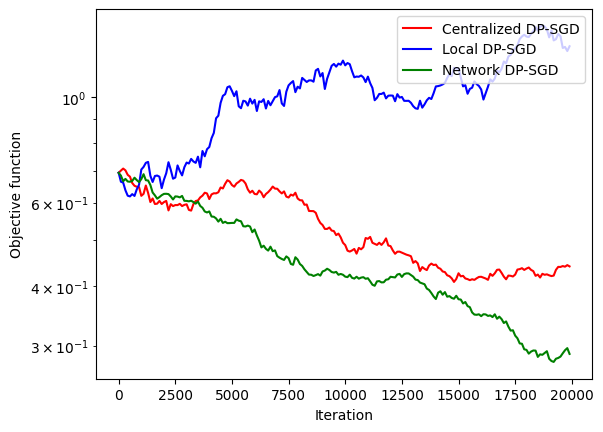

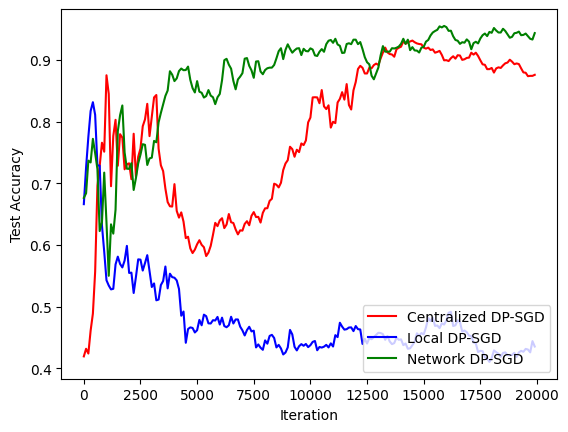

In [ ]:
import findSigma
import data
import private

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import typer





app = typer.Typer()

###############################################################################
# Set the parameters
###############################################################################


def main(
    n_nodes: int=200,
    eps_tot: float=10,
    delta: float=1e-6,
    n_iter: int=20000,
    conf: float=1.25,
    L: float=0.4,
    seed: int=1,
    n_trials: int=1,
    optimize_gamma: bool=False,
    save_array: bool=False,
    save_fig: bool=False,
    plot_fig: bool=True
    ):

    assert 0 <= delta <= 1
    assert 0 <= L <= 1

    np.random.seed(seed)

    X_train, X_test, y_train, y_test = data.load()
    print("Successfully load dataset")



    ###########################################################################
    # Find max sigma
    ###########################################################################

    print("Computing the sigmas:")
    # for local DP, with advanced composition
    sigma_loc = findSigma.loc(L, n_nodes, eps_tot, delta, n_iter)

    # for central DP, basic DPSGD result based on Bassily et al.
    sigma_ref = findSigma.dpsgd(L, n_nodes, eps_tot, delta, n_iter)

    # for network DP, bound with paper result
    sigma_net = findSigma.net(L, n_nodes, eps_tot, delta, n_iter)




    def score(y):
        # defining score to be able to evaluate the model on the test set during the training
        def evaluation(theta):
            from sklearn.linear_model._base import LinearClassifierMixin, SparseCoefMixin
            from sklearn.utils.validation import validate_data
            from sklearn.base import BaseEstimator
            class Truc(BaseEstimator, LinearClassifierMixin):
                def __init__(self):
                    self.intercept_ = np.expand_dims(theta[-1], axis=0)
                    self.coef_ = np.expand_dims(theta[:-1], axis=0)
                    self.classes_ = np.unique(y)

                def fit(self, X, y):
                    pass

            truc = Truc()

            return truc.score(X_test, y_test)

        return evaluation


    ###########################################################################
    # find optimal gamma for the three cases
    ###########################################################################


    n_train = X_train.shape[0]
    print('size of n ',n_train)

    best_gamma = np.array([0.06733333, 0.03416667, 0.03416667])

    if optimize_gamma:
        gamma_range = np.linspace(1e-3, .2, num=7)

        print("Testing various gamma", gamma_range)

        for i,sigma in enumerate([sigma_loc, sigma_ref, sigma_net]):
            print("optimizing ", sigma)

            best_objfun = 0
            for gamma in gamma_range:

                n_runs = 6
                objfun = np.zeros(n_runs)
                if sigma != sigma_ref:
                    mlr = private.MyPrivateRWSGDLogisticRegression(gamma, n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = conf *n_iter + n_iter/n_nodes,random_state=None, score=score, freq_obj_eval=1000, L=L)
                else :
                    mlr = private.MyPrivateRWSGDLogisticRegression(gamma, n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = n_iter,random_state=None, score=score, freq_obj_eval=1000, L=L)

                for r in range(n_runs):
                    mlr.fit(X_train, y_train)
                    objfun[r] = mlr.obj_list_[-1]
                if objfun.mean() < best_objfun:
                    best_objfun = objfun.mean()
                    best_gamma[i] = gamma


        print("Found the following :", best_gamma)
        if save_array:
            np.save('result/gamma.txt', best_gamma)


    ###########################################################################
    # Core experiments n_trials runs for the three methods
    ###########################################################################

    freq_eval = 100
    obj_list_ref = np.zeros((n_trials, int(n_iter/freq_eval)))
    obj_list_loc = np.zeros((n_trials, int(n_iter/freq_eval)))
    obj_list_net = np.zeros((n_trials, int(n_iter/freq_eval)))

    score_ref = np.zeros((n_trials, int(n_iter/freq_eval)))
    score_loc = np.zeros((n_trials, int(n_iter/freq_eval)))
    score_net = np.zeros((n_trials, int(n_iter/freq_eval)))



    for i in range(n_trials):
        print("Computing trial ", i)
        # put option contribution the noise, but with a max number of iteration equal to the whole experiment, so we always compute the gradient
        mlr_ref = private.MyPrivateRWSGDLogisticRegression(best_gamma[1], n_iter, n_nodes, sigma_ref, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = n_iter,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_ref.fit(X_train, y_train)

        mlr_loc = private.MyPrivateRWSGDLogisticRegression(best_gamma[0], n_iter, n_nodes, sigma_loc, 0, stopping_criteria = "contribute_then_nothing",max_updates_per_node = conf * n_iter/n_nodes,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_loc.fit(X_train, y_train)

        mlr_net = private.MyPrivateRWSGDLogisticRegression(best_gamma[2], n_iter, n_nodes, sigma_net, 0, stopping_criteria = "contribute_then_noise",max_updates_per_node = conf * n_iter/n_nodes,random_state=np.random.randint(1000), score=score, freq_obj_eval=freq_eval, L=L)
        mlr_net.fit(X_train, y_train)


        obj_list_ref[i] = mlr_ref.obj_list_
        obj_list_loc[i] = mlr_loc.obj_list_
        obj_list_net[i] = mlr_net.obj_list_

        score_ref[i] = mlr_ref.scores_
        score_loc[i] = mlr_loc.scores_
        score_net[i] = mlr_net.scores_

    ###########################################################################
    # save objective function and score over iterations
    ###########################################################################

    if save_array:
        np.save("result/dpsgd", obj_list_ref)
        np.save("result/localsgd", obj_list_loc)
        np.save("result/networksgd", obj_list_net)

        np.save("result/dpsgd_score",score_ref)
        np.save("result/localsgd_score",score_loc)
        np.save("result/networksgd_score", score_net)


    ###########################################################################
    # plot figure and save them
    ###########################################################################

    if plot_fig:
        # define x axis
        iter_list = np.arange(len(obj_list_ref[0])) * mlr_ref.freq_obj_eval
        # plot
        plt.plot(iter_list, obj_list_ref.mean(axis=0), label="Centralized DP-SGD", color="r")
        plt.plot(iter_list, obj_list_loc.mean(axis=0), label="Local DP-SGD", color="b")
        plt.plot(iter_list, obj_list_net.mean(axis=0), label="Network DP-SGD", color="g")

        plt.xlabel("Iteration")
        plt.ylabel("Objective function")
        plt.yscale("log")
        plt.legend(loc='upper right')
        if save_fig:
            plt.savefig("result/objfun.pdf")
        plt.show()


        plt.figure()
        plt.plot(iter_list, score_ref.mean(axis=0), label="Centralized DP-SGD", color="r")
        plt.plot(iter_list, score_loc.mean(axis=0), label="Local DP-SGD", color="b")
        plt.plot(iter_list, score_net.mean(axis=0), label="Network DP-SGD", color="g")

        plt.xlabel("Iteration")
        plt.ylabel("Test Accuracy")
        plt.legend(loc='lower right')
        if save_fig:
            plt.savefig("result/accuracy.pdf",bbox_inches='tight', pad_inches=0)

        plt.show()
if __name__ == "__main__":
    # typer.run(main)  # Replace this line
    main()  # Directly call main function instead